In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Parameters

In [91]:
reduced = False
dataset_to_fit = 'android_data_latest'
if dataset_to_fit == 'html_data':
    device = 'iphone'
data_type = 'wlk'
data_fit_num = 5

dataset_source_type = 'wlk_7'
dataset_source_num = 4

# Load Data

### Original Data

In [92]:
data_source_url = '../data/dataset'
if reduced:
    data_source_url += '_reduced'

data_source = pd.read_csv(data_source_url + '/' + dataset_source_type + '/sub_{}'.format(dataset_source_num) + '.csv')
data_source = data_source.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_source.columns else None
data_source

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.569732,-1.344266,-1.316934,-0.121138,0.974452,-0.189103,-1.811013,0.851841,-1.083774,-0.779741,0.495672,0.594301
1,-0.721397,-1.359857,-1.513063,-0.138265,0.977835,-0.157201,-1.819990,2.591707,-1.137348,-0.416377,0.541651,0.354757
2,-0.783814,-1.362296,-1.637286,-0.146117,0.978342,-0.146581,-0.312856,2.677489,-0.719938,-0.162065,0.567739,-0.526576
3,-0.843923,-1.361021,-1.717798,-0.155590,0.978078,-0.138367,-1.028269,0.311309,-0.581966,-0.059711,-0.361272,0.916244
4,-0.963102,-1.372325,-1.850983,-0.161848,0.980369,-0.112564,-1.584632,1.038291,-0.216111,0.075652,-0.448585,0.873779
...,...,...,...,...,...,...,...,...,...,...,...,...
6466,2.777965,-1.396517,2.101557,0.061636,0.984852,0.161966,-0.752626,-0.267981,-0.164063,0.076166,-0.070347,0.081533
6467,2.824490,-1.381503,2.147944,0.058643,0.982137,0.178694,-0.888023,0.235275,-0.158176,0.105572,-0.046499,0.047472
6468,2.882559,-1.366061,2.201221,0.052053,0.979115,0.196437,-0.881749,0.229726,-0.373906,0.133692,0.118724,-0.085262
6469,2.944159,-1.349287,2.266074,0.043079,0.975567,0.215352,-1.083126,-0.314477,-0.503870,0.171902,0.122944,-0.341450


### Data to Fit

In [93]:
data_to_fit_url = '../data/' + dataset_to_fit

if reduced:
    data_to_fit_url += '_reduced'

if dataset_to_fit == 'android_data_latest':
    data_to_fit = pd.read_csv(data_to_fit_url + '/' + data_type + '/{}{}'.format(data_type, data_fit_num) + '-SensorData.csv')
    data_to_fit = data_to_fit.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_to_fit.columns else data_to_fit
    data_to_fit = data_to_fit.drop('id', axis=1) if 'id' in data_to_fit.columns else data_to_fit

if dataset_to_fit == 'html_data':
    data_to_fit = pd.read_csv(data_to_fit_url + '/' + device + '/' + data_type + '/{}_{}'.format(data_type, data_fit_num) + '.csv')
    data_to_fit = data_to_fit.drop('Unnamed: 0', axis=1) if 'Unnamed: 0' in data_to_fit.columns else data_to_fit

data_to_fit

,Attitude Roll,Attitude Pitch,Attitude Azimuth,Gravity X,Gravity Y,Gravity Z,Rotation Rate X,Rotation Rate Y,Rotation Rate Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
1,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
2,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
3,0.667742,2.499000,-2.874172,2.802586,-9.396373,-0.155226,-0.002059,0.001346,0.003886,-0.053072,-0.148451,-0.302652
4,0.667742,2.499000,-2.874172,2.802586,-9.396373,-0.155226,-0.002059,0.001346,0.003886,-0.053072,-0.148451,-0.302652
...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1799,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1800,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1801,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049


In [94]:
# Removing Outliers from Data
def remove_outliers(df):
    result = df.copy()
    for feature in df.columns:
        if pd.api.types.is_numeric_dtype(df[feature]):
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            result = result[(result[feature] >= lower_bound) & (result[feature] <= upper_bound)]
    return result

data_to_fit = remove_outliers(data_to_fit)

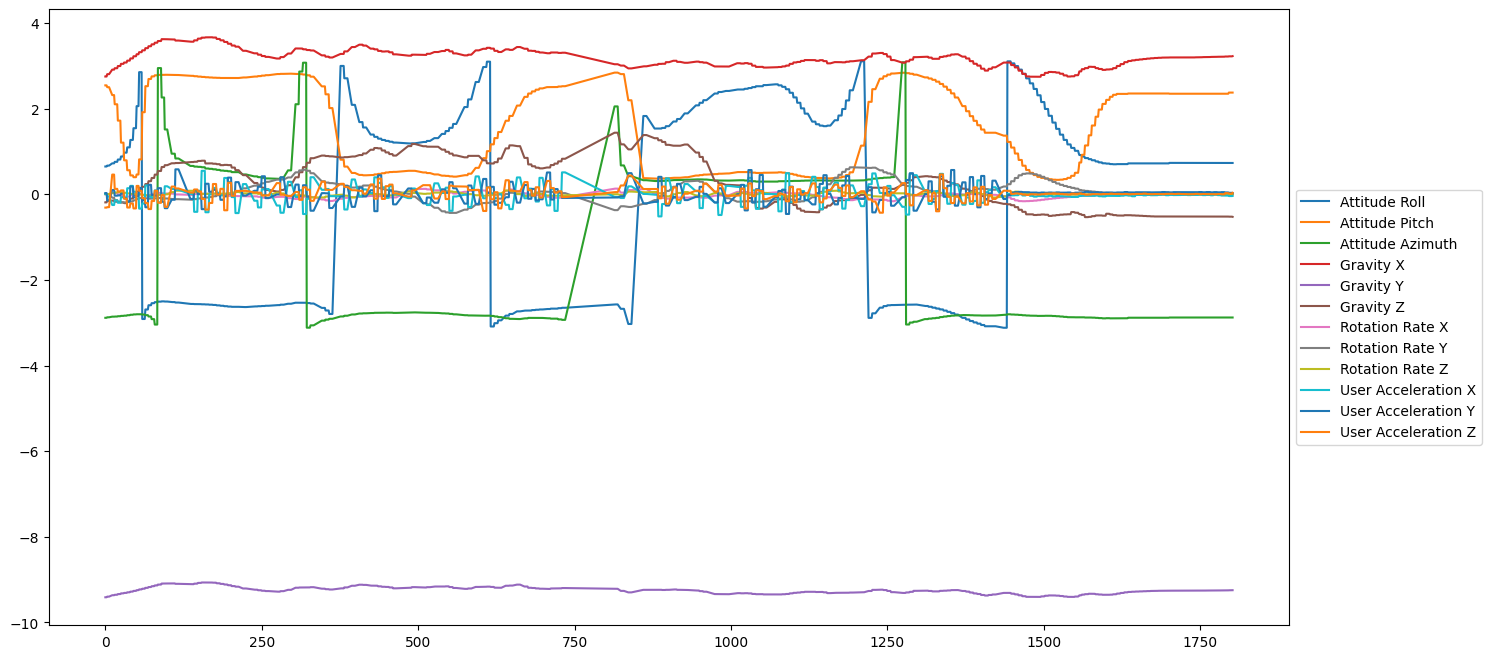

In [95]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(data_to_fit)
plt.legend(data_to_fit.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

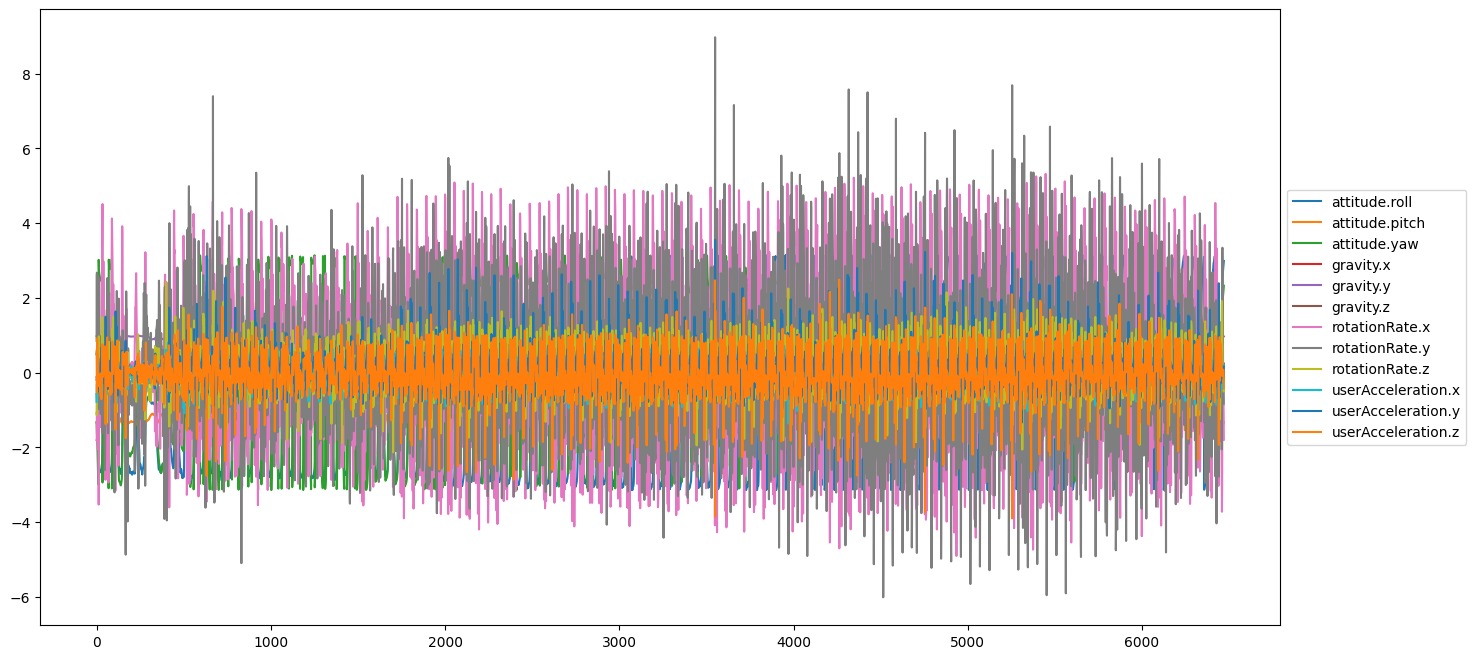

In [96]:
plt.figure(figsize=(16, 8))
plt.plot(data_source)
plt.legend(data_source.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fit the Length

In [72]:
if len(data_source) >= len(data_to_fit):
    data_source = data_source[:len(data_to_fit)]
else:
    data_to_fit = data_to_fit[:len(data_source)]

print('Data source shape: {}'.format(data_source.shape))
print('Data to fit shape: {}'.format(data_to_fit.shape))

Data source shape: (1803, 12)
Data to fit shape: (1803, 12)


# Calculate Factor with Linear Regression

In [73]:
# find scaling factor of each column wuth linear regression (fit android data to original data)
def calculate_scaling_factors(df, df_o):
    scaling_factors = {}

    for i in range(len(df.columns)):
        X = df.iloc[:, i].values.reshape(-1, 1)
        y = df_o.iloc[:, i].values.reshape(-1, 1)

        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        scaling_factors[df.columns[i]] = model.coef_[0][0]

    return scaling_factors

In [74]:
# predict
scaling_factors = calculate_scaling_factors(data_to_fit, data_source)
scaling_factors

{'Attitude Roll': 0.10221185575559373,
 'Attitude Pitch': -0.579862596228045,
 'Attitude Azimuth': 0.149674824612691,
 'Gravity X': -0.03662049398772467,
 'Gravity Y': -0.10313028288385923,
 'Gravity Z': 0.013434455373251402,
 'Rotation Rate X': -0.9411218581638958,
 'Rotation Rate Y': -0.04620051888800989,
 'Rotation Rate Z': -0.0361597418352225,
 'User Acceleration X': -0.02147556597863703,
 'User Acceleration Y': 0.1246765894102864,
 'User Acceleration Z': 0.0985925988387502}

# Save Scaling Factors

In [77]:
# Write to Constants File
constant_file_url = '../constants.txt'
if reduced:
    constant_file_url = '../constants_reduced.txt'

with open(constant_file_url, 'a') as f:
    f.write(str(scaling_factors) + '\n')

In [78]:
# opening scaling factor file to read the dictionary
factors = []
with open(constant_file_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))

factors

[{'Attitude Roll': 0.10221185575559373,
  'Attitude Pitch': -0.579862596228045,
  'Attitude Azimuth': 0.149674824612691,
  'Gravity X': -0.03662049398772467,
  'Gravity Y': -0.10313028288385923,
  'Gravity Z': 0.013434455373251402,
  'Rotation Rate X': -0.9411218581638958,
  'Rotation Rate Y': -0.04620051888800989,
  'Rotation Rate Z': -0.0361597418352225,
  'User Acceleration X': -0.02147556597863703,
  'User Acceleration Y': 0.1246765894102864,
  'User Acceleration Z': 0.0985925988387502}]